# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
!pip install -q transformers
!pip install -q datasets
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import transformers
from transformers import AutoModel, BertTokenizerFast, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from datasets import load_metric
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.graph_objs as go 
import os
import warnings
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np        
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
import pandas as pd
from PIL import Image
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 15.7 MB/s eta 0:00:00


# Download Data

In [2]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!gdown https://drive.google.com/uc?id=1L787y_gjEaw45Yv41oFGkFYW8gTj1h9P

Downloading...
From: https://drive.google.com/uc?id=1L787y_gjEaw45Yv41oFGkFYW8gTj1h9P
To: /content/dialect_dataset_cleaned.csv
100% 52.0M/52.0M [00:00<00:00, 67.2MB/s]


# Read Data

In [13]:
df = pd.read_csv("/content/dialect_dataset_cleaned.csv")

In [14]:
df.head()

,dialect,text
0,TN,ناس بكري قالوا طيح وشوف شكون يوقف معاك غيب وشو...
1,TN,تهبل والله فنانه مبدعه انت ماشاء الله
2,TN,الله يبارك فيك يعيشك
3,TN,عيدكم مبروك وسنين دايمه دلوع
4,TN,الله يسلمك دلوع الغاليه ويمتعك بالصحه والعافيه...


In [15]:
df.isna().sum()

dialect      0
text       172
dtype: int64

In [16]:
df.dropna(inplace=True)

## Split Data

In [17]:
def seed_everything(seed=1234):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
seed_everything()

In [18]:
df_train, df_test= train_test_split(df, test_size=0.006, random_state=42)
df_train,df_val = train_test_split(df_train,test_size=0.01, random_state=42)

# Preparing data and model

In [19]:
df_train['dialect'].unique()

array(['SA', 'PL', 'KW', 'EG', 'JO', 'LB', 'DZ', 'BH', 'QA', 'IQ', 'TN',
       'LY', 'SY', 'YE', 'AE', 'OM', 'SD', 'MA'], dtype=object)

In [20]:
encode_labels = {d: i for i, d in enumerate(df_train['dialect'].unique())}

In [21]:
df_train['dialect'] = df_train['dialect'].map(encode_labels)
df_test['dialect'] = df_test['dialect'].map(encode_labels)
df_val['dialect'] = df_val['dialect'].map(encode_labels)

In [22]:
model = AutoModelForSequenceClassification.from_pretrained('aubmindlab/bert-base-arabert', num_labels=len(df_train['dialect'].unique()))
tokenizer = BertTokenizerFast.from_pretrained('aubmindlab/bert-base-arabert')

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [23]:
sequence = []
for i in df_train['text'].tolist():
  sequence.append(len(tokenizer.encode(i)))

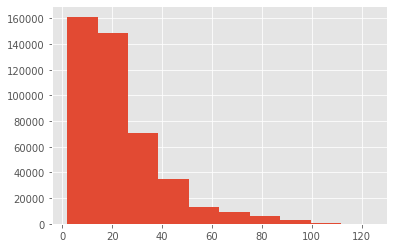

In [24]:
plt.hist(sequence);

In [25]:
max_seq_len = max(sequence)

In [26]:
train = tokenizer(df_train['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
val= tokenizer(df_val['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
test = tokenizer(df_test['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)

In [27]:
train_labels = df_train['dialect']
val_labels = df_val['dialect']
test_labels = df_test['dialect']

In [28]:
class QadiDataset(Dataset):
  def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels.to_list()

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx])
      return item

  def __len__(self):
      return len(self.labels)


In [29]:
ds_train = QadiDataset(train, train_labels)
ds_val =  QadiDataset(val, val_labels)
ds_test = QadiDataset(test, test_labels)

In [30]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  f1 = f1_score(labels, predictions, average='macro')
  acc = accuracy_score(labels, predictions)
  return {
      'accuracy': acc,
      'f1': f1,
  }

In [32]:
device = torch.device("cuda:0")
# model.to(device)

In [34]:
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=6,              
    per_device_train_batch_size=64,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=0.01,              
    evaluation_strategy='epoch',
    learning_rate = 2e-05,
    save_strategy = 'epoch',
    load_best_model_at_end=True
    )

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=ds_train,         
    eval_dataset=ds_val,             
    compute_metrics=compute_metrics
)



# Training

In [ ]:
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
***** Running training *****
  Num examples = 447489
  Num Epochs = 6
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 41958


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.693700,1.632997,0.477770,0.447868
2,1.490000,1.533570,0.513603,0.487904
3,1.334600,1.489712,0.533510,0.506341
4,1.204600,1.503390,0.537934,0.511704
5,1.122000,1.526209,0.536828,0.513137
6,1.035200,1.546929,0.539040,0.514628


***** Running Evaluation *****
  Num examples = 4521
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-6993
Configuration saved in ./results/checkpoint-6993/config.json
Model weights saved in ./results/checkpoint-6993/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4521
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-13986
Configuration saved in ./results/checkpoint-13986/config.json
Model weights saved in ./results/checkpoint-13986/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4521
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-20979
Configuration saved in ./results/checkpoint-20979/config.json
Model weights saved in ./results/checkpoint-20979/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4521
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-27972
Configuration saved in ./results/checkpoint-27972/config.json
Model weights saved in ./results/checkpoint-27972/p

TrainOutput(global_step=41958, training_loss=1.3634675710227062, metrics={'train_runtime': 28772.1576, 'train_samples_per_second': 93.317, 'train_steps_per_second': 1.458, 'total_flos': 1.7111450310580883e+17, 'train_loss': 1.3634675710227062, 'epoch': 6.0})

## Save model checkpoint

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !cp -r /content/results/checkpoint-4614 /content/drive/MyDrive/sample100k-checkpoint-4614

In [ ]:
trainer.save_model('./all_checkpoint524')

Saving model checkpoint to ./all_checkpoint524
Configuration saved in ./all_checkpoint524/config.json
Model weights saved in ./all_checkpoint524/pytorch_model.bin


In [ ]:
!zip -r all_checkpoint524F1_last.zip /kaggle/working/results/checkpoint-41958

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: kaggle/working/results/checkpoint-41958/ (stored 0%)
  adding: kaggle/working/results/checkpoint-41958/trainer_state.json (deflated 81%)
  adding: kaggle/working/results/checkpoint-41958/config.json (deflated 63%)
  adding: kaggle/working/results/checkpoint-41958/scheduler.pt (deflated 50%)
  adding: kaggle/working/results/checkpoint-41958/pytorch_model.bin (deflated 7%)
  adding: kaggle/working/results/checkpoint-41958/rng_state.pth (deflated 27%)
  adding: kaggle/working/results/checkpoint-41958/training_args.bin (deflated 48%)
  adding: kaggle/working/results/checkpoint-41958/optimizer.pt (deflated 27%)


In [ ]:
%cd /kaggle/working

/kaggle/working


In [ ]:
from IPython.display import FileLink
FileLink(r'kaggle/working/results/checkpoint-41958/training_args.bin')

/kaggle/working/all_checkpoint524.zip

# Testing

In [ ]:
preds = trainer.predict(ds_test)

***** Running Prediction *****
  Num examples = 2729
  Batch size = 64


In [ ]:
y_pred = [ np.argmax(i, axis=-1) for i  in preds[0]]
y_test = ds_test.labels

In [ ]:
f1_score(y_test, y_pred, average='macro')

0.5243593469093176

In [ ]:
accuracy_score(y_test, y_pred)

0.5503847563209967

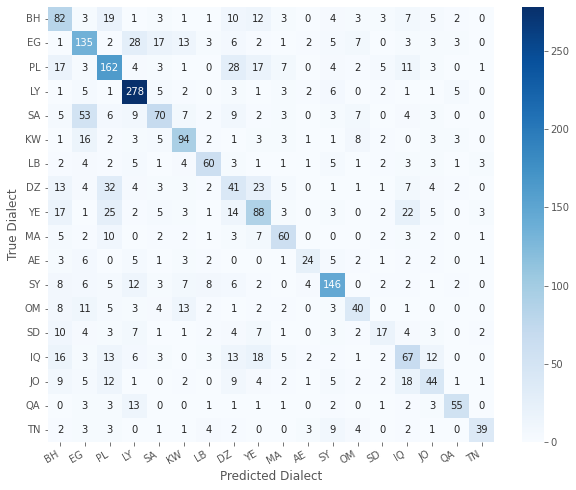

In [ ]:
class_name = ['BH', 'EG', 'PL', 'LY', 'SA', 'KW', 'LB', 'DZ', 'YE', 'MA', 'AE','SY', 'OM', 'SD', 'IQ', 'JO', 'QA', 'TN']

def show_confusion_matrix(confusion_matrix):
  plt.figure(figsize=(10, 8))
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Dialect')
  plt.xlabel('Predicted Dialect');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

# Inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [9]:
!cp -r /content/drive/MyDrive/all_checkpoint524 /content/

In [ ]:
!unzip /content/all_checkpoint524/all_checkpoint524.zip

In [6]:
tokenizer = BertTokenizerFast.from_pretrained('aubmindlab/bert-base-arabert')

Downloading:   0%|          | 0.00/637 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/717k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

In [35]:
Model_checkpoint = AutoModelForSequenceClassification.from_pretrained("/content/kaggle/working/all_checkpoint524/")
inf_trainer = Trainer(
    model=Model_checkpoint,                       
    args=training_args,                 
    train_dataset=ds_train,        
    eval_dataset=ds_val,             
    compute_metrics=compute_metrics
)
inf_preds = inf_trainer.predict(ds_test)

loading configuration file /content/kaggle/working/all_checkpoint524/config.json
Model config BertConfig {
  "_name_or_path": "/content/kaggle/working/all_checkpoint524/",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LA

In [36]:
y_pred = [ np.argmax(i, axis=-1) for i  in inf_preds[0]]
y_test = ds_test.labels

In [37]:
print('F1-Score =  ',f1_score(y_test, y_pred, average='macro')*100,"%")
print('Accuracy = ',accuracy_score(y_test, y_pred)*100,"%")

F1-Score =   52.43593469093176 %
Accuracy =  55.03847563209967 %


In [38]:
def predict(Trainer,tokenizer,sentence):
  countries = {'AE':'United Arab Emirates','BH':'Bahrain','DZ':'Algeria','EG':'Egypt',
 'IQ':'Iraq','JO':'Jordan','KW':'Kuwait','LB':'Lebanon','LY':'Libya','MA':'Morocco','OM':'Oman','PL':'Palastine','QA':'Qatar',
 'SA':'Saudi Arabia','SD':'Sudan','SY':'Syria','TN':'Tunisia','YE':'YEMEN'}
  data = [[0, sentence]]
  inf_df = pd.DataFrame(data, columns = ['dialect', 'text'])
  test_labels = inf_df['dialect']
  test_encodings = tokenizer(inf_df['text'].to_list(), truncation=True, padding=True, max_length=max_seq_len)
  test_dataset = QadiDataset(test_encodings, test_labels)
  pred = Trainer.predict(test_dataset)
  pred = np.argmax(pred[0],axis=-1)
  return countries[list(encode_labels.keys())[list(encode_labels.values()).index(pred[0])]]

In [39]:
predict(inf_trainer,tokenizer,"والنبي انتي عسل ودمك زي السكر")

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


'Egypt'

In [40]:
predict(inf_trainer,tokenizer,"ثمكي شكله زي هيك")

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


'Jordan'